# Hawk-Dove Dynamics

In [1]:
import numpy as np
# Plotting libraries
import matplotlib.pylab as plt
# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline
# This enables high resolution PNGs.
%config InlineBackend.figure_formats = {'png', 'svg'}

## Evolutionary Dynamics of the Haw-Dove Game in Infinite populations

### Replicator equation

The replicator equation represents the dynamics of competing individuals in a population. It normally found in the following form:

$\dot{x}_i = x_i[f(x_i)-\sum_{i=1}^{n}x_if(x_i)]$,

where $x_i$ represents the frequency of strategy $i$ in the population, and $f(x_i)$ is the fitness of strategy $i$. This differencial equation, gives the gradient of selection, i.e., the strength with which the frequency of a certain strategy will increase or decrease. It may also be expressed in a more convenient matrix form:

$G(x_i) = \dot{x}_i = x_i[(Ax)_i - x^TAx]$

Where the matrix $A$ is a payoff matrix with element $A_{ij}$ representing the fitness of strategy $i$ over strategy $j$.

In [2]:
from egttools.analytical import replicator_equation
from egttools.analytical.utils import (calculate_gradients, find_roots, check_replicator_stability_pairwise_games,)
from egttools.plotting import plot_gradients

In [3]:
# Payoff matrix
V = 2; D = 3; T = 1
A = np.array([
        [ (V-D)/2, V],
        [ 0      , (V/2) - T],
    ])

Now we can calculate the gradient of selection of the replicator equation and plot it

In [4]:
nb_points = 101
strategy_i = np.linspace(0, 1, num=nb_points, dtype=np.float64)

In [5]:
# Calculate gradient
gradient_function = lambda x: replicator_equation(x, A)
gradients = calculate_gradients(np.array((strategy_i, 1 - strategy_i)).T, gradient_function)

When we are analysing a pairwise game with the replicator equation, we can also calculate the roots of the system and their stability:

In [6]:
roots = find_roots(gradient_function, 2, nb_initial_random_points=10, method="hybr")
stability = check_replicator_stability_pairwise_games(roots, A, atol_neg=1e-4, atol_pos=1e-4, atol_zero=1e-4)

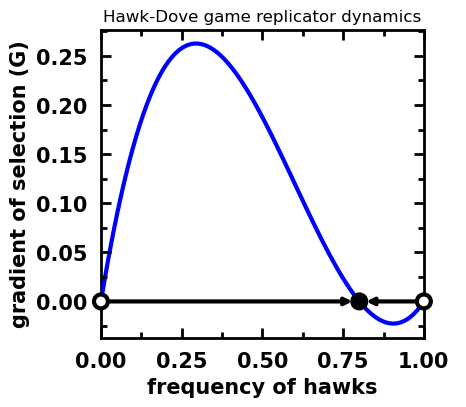

In [7]:
plot_gradients(gradients[:, 0], figsize=(5,4), fig_title="Hawk-Dove game replicator dynamics", 
               xlabel="frequency of hawks", roots=roots, stability=stability)
plt.show()

## Evolutionary Dynamics of the Hawk-Dove Game in Finite populations

Now we are going to study the effect of having Finite populations. In general, finite populations introduce stochastic effects in the dynamics, also known as random drift $~ 1/Z$, where $Z$ is the size of the population. We can represent these dynamics, by adapting the replicator equation, which considers that individuals are sampled from an infinite population, and therefore selecting a member of strategy $j$ does not reduce its frequency in the population. When the population is finite, we make no longer assume a sampling with replacement, i.e., when an individual of strategy $j$ is sampled, the fraction of members of that strategy is reduced, instead we must sample without replacement.

Here the fitness of an strategy $i$ against strategy $j$ directly depends on the size of the population:

$f_i(x_i, Z) = \frac{x_i - 1}{Z-1} * A_{ii} + \frac{Z - x_i}{Z-1} * A_{ij}$

For the selection dynamics, we use a Moran process (or birth-death process) with pair-wise comparison: at each step, 2 individuals, $a$ and $b$, are randomly sampled (without replacement) from the population, and their payoff is compared. The fermi equation gives the probability that individual $a$ (selected for death) will copy the strategy of individual $b$ (selected for birth):

$p=[1 + e^{\beta(f_a-f_b)}]^{-1}$

$a$ will imitate $b$ with probability $p$, in any other case, the population state will not change. $\beta$ indicates the selection strength and on the limit $\beta \xrightarrow{} 0$ all strategies are immitated with equal probability.

In [8]:
from egttools.analytical import StochDynamics

In [9]:
# Parameters and evolver
nb_strategies = 2; Z = 100; N = 2;
beta = 1
pop_states = np.arange(0, Z + 1, 1)
strategy_i = np.linspace(0, 1, num=Z + 1, dtype=np.float64)
evolver = StochDynamics(nb_strategies, A, Z)

In [10]:
gradients = np.array([evolver.gradient_selection(x, 0, 1, beta) 
                      for x in pop_states])

<AxesSubplot:title={'center':'Hawk-Dove game stochastic dynamics'}, xlabel='frequency of hawks (k/Z)', ylabel='gradient of selection (G)'>

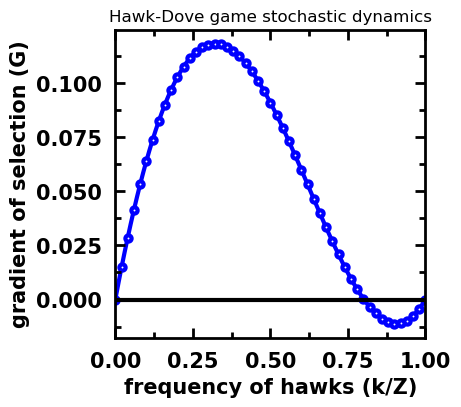

In [11]:
plot_gradients(gradients, figsize=(4,4), fig_title="Hawk-Dove game stochastic dynamics", 
               marker_facecolor='white',
               xlabel="frequency of hawks (k/Z)", marker="o", marker_size=20, marker_plot_freq=2)

#### Now let's calculate the stationary distribution

In [12]:
from egttools.utils import calculate_stationary_distribution
from egttools.plotting import draw_stationary_distribution

In [13]:
#calculate stationary distributions using eigenvalues and eigenvectors
evolver.mu = 0
t,f = evolver.transition_and_fixation_matrix(beta)
sd = calculate_stationary_distribution(t)

/Users/eliasfernandez/PycharmProjects/EGTtools/egttools/utils.py:208: RuntimeWarning: Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in more than one eigenvalue of magnitute 1 (the Markov Chain is degenerate), so please be careful when analysing the results.
  warn(


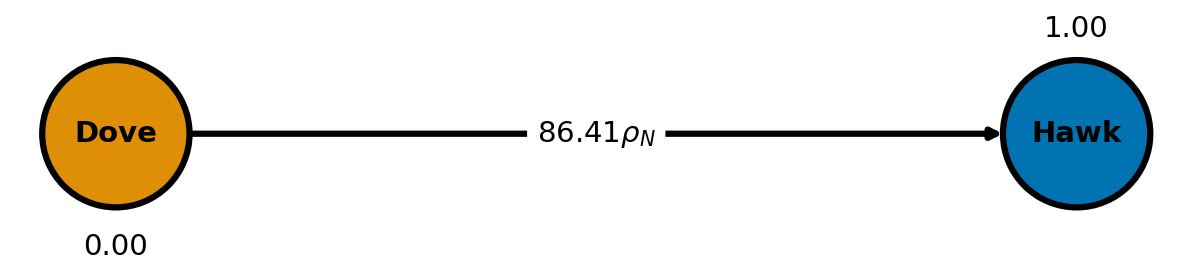

In [14]:
fig, ax = plt.subplots(figsize=(10, 2), dpi=150)

G = draw_stationary_distribution(['Hawk', 'Dove'],
                                 1/Z, f, sd, max_displayed_label_letters=6,
                                 node_size=5000, 
                                 min_strategy_frequency=-0.1, 
                                 font_size_node_labels=14,
                                 font_size_edge_labels=14,
                                 font_size_sd_labels=14,
                                 edge_width=3,
                                 node_linewidth=3,
                                 node_edgecolors='black',
                                 node_labels_top_separation=0.008,
                                 node_labels_bottom_separation=-0.01,
                                 ax=ax)

plt.axis('off')
plt.show() # display

#### Introducing mutations

If we introduce mutations, i.e., there is a probability that individuals make an error, and adopt a different strategy instead of imitating the best, the dynamics may change. In this case, at each time step, players are selected for death/birth and their fitness is compared. 

However, now, with probability $\mu$ agent $a$ will adopt a random strategy from the strategy space, and with probability $1-\mu$ it will immitate $b$ with probability $p$. Therefore the probability of immitating $b$ is $p_{eff} = (1-\mu)*p$. On the limit $\mu \xrightarrow{} 1$, all strategies are taken with equal probability. When $\mu \xrightarrow{} 0$ we go back to the previous case, also known as small mutation limit (SML). 

When mutation is small, we may assume that only the the states in which all population adopts a single strategy, also known as monomorphic states, are absorbing and stable. This is because, since there are no mutations, once the population reaches a monomorphic state, it will never leave. Such a simplification, allows us to reduce the number of states of the system, taking the Hawk-Dove game as an example, from Z + 1, to only 2.

Moreover, mixed equilibria are no longer stable in the SML. This occurs, since random drift, even if it takes an infinite ammount of time (please note that we are not looking at fixation times), will drive the population to one of the monomorphic states. For this reason, the SML assumption is only reasonable when we know that there are no mixed stable attractors in the studied system, which is not the case in the Hawk-Dove game. This explains why the results of the stationary distribution differ from the previously calculated Nash equilibria.

Now we are going to calculate the stationary distribution again, but taking mutations into account.

In [15]:
evolver.mu = 1e-3
stationary_with_mu = evolver.calculate_stationary_distribution(beta)

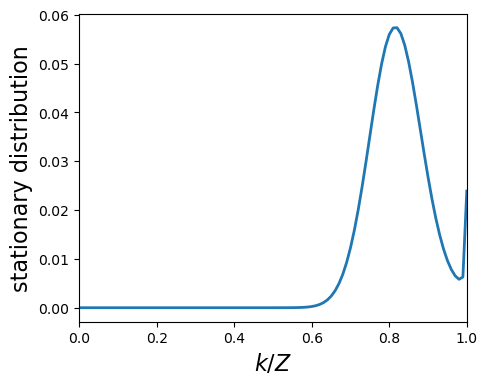

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_facecolor('white')
lines = ax.plot(np.arange(0, Z+1)/Z, stationary_with_mu[::-1])
plt.setp(lines, linewidth=2.0)
ax.set_ylabel('stationary distribution',size=16)
ax.set_xlabel('$k/Z$',size=16)
ax.set_xlim(0, 1)
plt.show()